In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteJKDC57/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteJKDC57/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


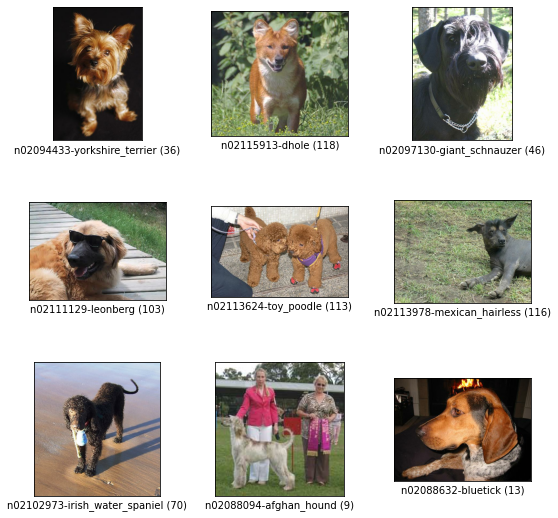

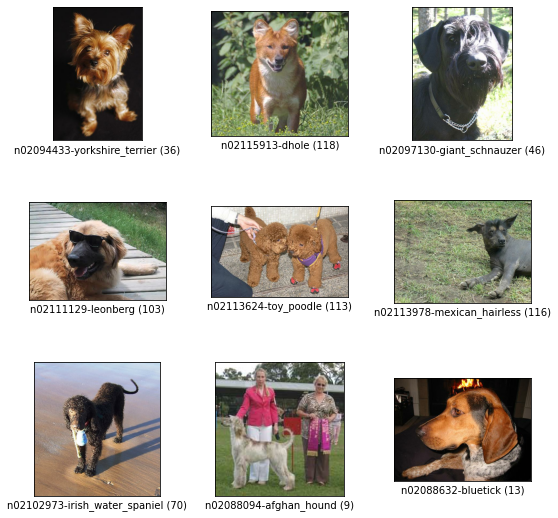

In [4]:
tfds.show_examples(ds_train, ds_info)

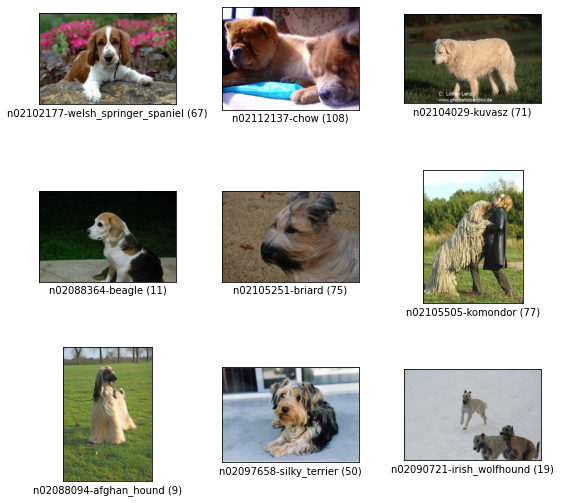

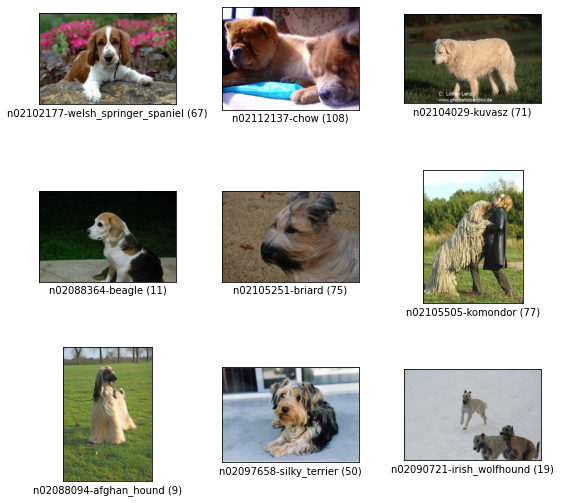

In [5]:
tfds.show_examples(ds_test, ds_info)

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [7]:
num_classes = ds_info.features['label'].num_classes
base_model = keras.applications.resnet50.ResNet50(       # ResNet50 모델을 기본으로 사용
    include_top = False,                   # fully connected layer 제거 
    weights = 'imagenet',                  # 이미지넷 가중치를 가져온다 
    input_shape = (224, 224, 3),             
    pooling = 'avg',                       # GAP를 사용
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)
cam_model = keras.Model(inputs = base_model.input, outputs = preds)

94781440/94765736 [==============================] - 0s 0us/step


In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [9]:
# 정규화 및 사이즈 변경
def normalize_and_resize_img(input):
    # Normalizes images : 'uint8' -> 'float32'
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test = False, batch_size = 16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls = 2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
tf.random.set_seed(2021)
cam_model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = 15,
    validation_data = ds_test_norm,
    verbose = 1,
    use_multiprocessing = True,
)

Epoch 1/15
750/750 [==============================] - 178s 214ms/step - loss: 2.2068 - accuracy: 0.4507 - val_loss: 3.5433 - val_accuracy: 0.1878
Epoch 2/15
750/750 [==============================] - 161s 215ms/step - loss: 0.7389 - accuracy: 0.7928 - val_loss: 1.1016 - val_accuracy: 0.6823
Epoch 3/15
750/750 [==============================] - 161s 214ms/step - loss: 0.2408 - accuracy: 0.9484 - val_loss: 0.9633 - val_accuracy: 0.7206
Epoch 4/15
750/750 [==============================] - 160s 213ms/step - loss: 0.0644 - accuracy: 0.9943 - val_loss: 0.9387 - val_accuracy: 0.7334
Epoch 5/15
750/750 [==============================] - 159s 213ms/step - loss: 0.0236 - accuracy: 0.9991 - val_loss: 0.9098 - val_accuracy: 0.7446
Epoch 6/15
750/750 [==============================] - 159s 212ms/step - loss: 0.0127 - accuracy: 0.9999 - val_loss: 0.9174 - val_accuracy: 0.7442
Epoch 7/15
750/750 [==============================] - 160s 213ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.9269 -

In [13]:
import os 
cam_model_path = '/content/drive/MyDrive/Going_deeper/cam_model.h5'
cam_model.save(cam_model_path)
print('저장 완료')

저장 완료


# Class Activation Map

In [14]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image
import urllib3
urllib3.disable_warnings()


In [15]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split = ['train', 'test'],
    shuffle_files = True,
    with_info = True,
)

In [16]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# CAM

In [17]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

40


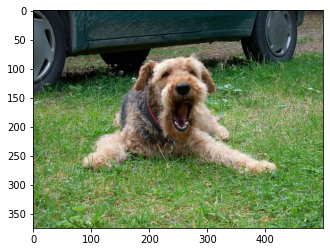

In [18]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [19]:
import os
cam_model_path = '/content/drive/MyDrive/Going_deeper/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [20]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)

# 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
# model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))

    conv_outputs = conv_outputs[0, :, :, :]    # 필요없는 맨앞의 차원을 버리고 변수에 저장
    class_weights = model.layers[-1].get_weights()[0]  # 모델 마지막 layer의 가중치를 가져온다 

    cam_image = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f를 통해 class별 activation map을 계산
        cam_image += w * conv_outputs[:, :, i]
    
    cam_image /= np.max(cam_image)  # activation score을 최대값으로 나눠서 정규화 
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))  # 원래 이미지의 크기로 resize 
    return cam_image

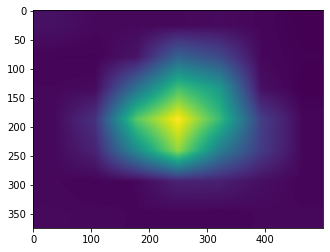

In [21]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [22]:
def visualize_cam_on_image(src1, src2, alpha = 0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

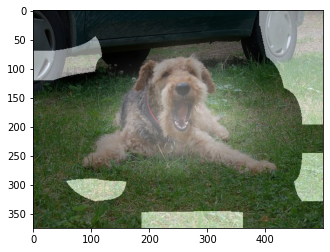

In [23]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image * 255] *3, axis = -1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

# Grad_CAM

40


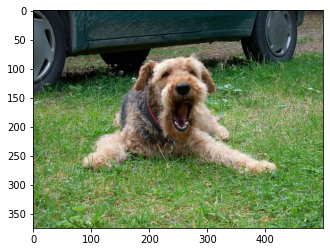

In [24]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [25]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])

    with tf.GradientTape() as tape :  # Gradient를 얻기 위해 tape를 사용 
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        loss = pred[:, class_idx]
        output = conv_output[0]
        grad_val = tape.gradient(loss, conv_output)[0]

    weights = np.mean(grad_val, axis = (0, 1))
    grad_cam_image = np.zeros(dtype = np.float32, shape = conv_output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]

    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

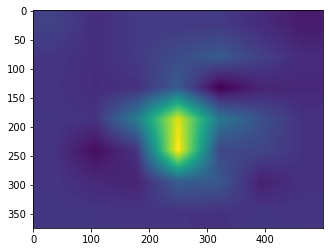

In [26]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

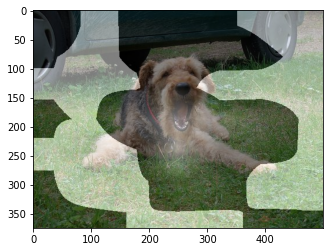

In [27]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image * 255]* 3, axis = -1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

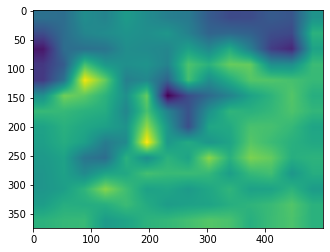

In [28]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

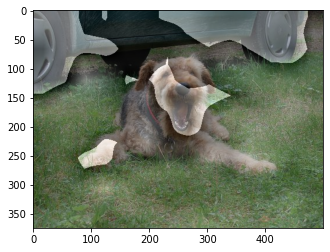

In [29]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

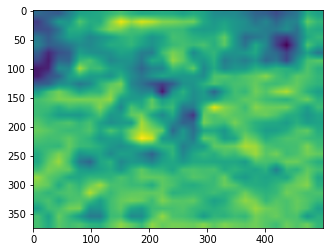

In [30]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

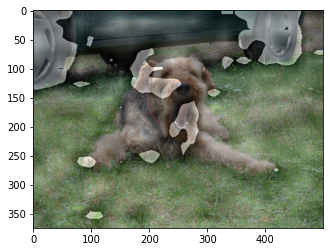

In [31]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image * 255] * 3, axis = -1).astype(np.uint8)
blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

# Detection with CAM

67


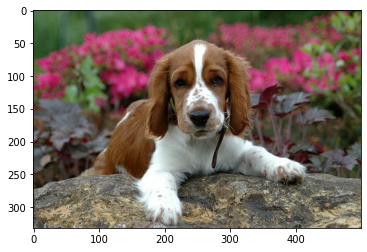

In [46]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

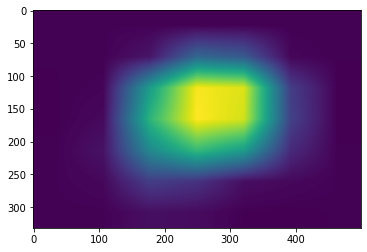

In [47]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [49]:
def get_bbox(cam_image, score_thresh = 0.05):
    low_indicies = cam_image <= score_thresh # 역치값 이하(0.05) 바운딩 박스는 없앤다
    cam_image[low_indicies] = 0
    cam_image = (cam_image * 255).astype(np.uint8)   # uint8 : 부호없는 8비트 정수형(0~255)

    contours, _ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # 컨투어 정보 찾기, 
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)  # 회전된 바운딩 박스 얻기(좌상단의 x좌표, y좌표, 가로와세로의 폭, 기울어진 각도 순으로 반환)
    rect = cv2.boxPoints(rotated_rect)  # 회전된 직사각형의 4개의 꼭지점을 찾는 함수, float형으로 2차원 포인터들의 집합으로 반환 
    rect = np.int0(rect)  # 각 좌표가 정수형이여야 하므로 해당 좌표를 int형으로 변환
    return rect

# image contour
## cv2.findContours - 외곽선 검출 함수 
1. 동일한 색 또는 동일한 픽셀값(강도,intensity)을 가지고 있는 영역의 경계선 정보(등고선처럼)
2. 물체의 윤곽선, 외형을 파악하는데 사용
3. OpenCV의 `findContours` 함수로 이미지의 컨투어 정보, 컨투어의 상하구조(hierachy) 정보를 출력한다. 흑백이미지 또는 이진화된 이미지만 적용할 수 있다.

`images, contours, hierachy  = cv2.findContours(image, mode, method)`

- image: 흑백이미지 또는 이진화된 이미지
- mode : 외곽선 검출 모드(cv2.RETR_로 시작하는 상수)
- method : 컨투어를 찾을 때 사용하는 근사화 방법(cv2.CHAIN_APPROX로 시작하는 상수)
- cv2.RETR_EXTERNAL: 컨투어 라인 중 가장 바깥쪽의 라인만 찾음
- cv2.RETR_LIST: 모든 컨투어 라인을 찾지만, 상하구조(hierachy)관계를 구성하지 않음
- cv2.RETR_CCOMP: 모든 컨투어 라인을 찾고, 상하구조는 2 단계로 구성함
- `cv2.RETR_TREE`: 모든 컨투어 라인을 찾고, 모든 상하구조를 구성함
- cv2.CHAIN_APPROX_NONE: 모든 컨투어 포인트를 반환
- `cv2.CHAIN_APPROX_SIMPLE`: 컨투어 라인을 그릴 수 있는 포인트만 반환(수직선, 수평선, 대각선에 대한 끝점만 저장)
- cv2.CHAIN_APPROX_TC89_L1: Teh_Chin 연결 근사 알고리즘 L1 버전을 적용하여 컨투어 포인트를 줄임
- cv2.CHAIN_APPROX_TC89_KCOS: Teh_Chin 연결 근사 알고리즘 KCOS 버전을 적용하여 컨투어 포인트를 줄임

### 외곽선 계층
![image](https://user-images.githubusercontent.com/97458432/161188585-cab89917-756b-4757-ab64-fb96ca748afd.png)

### 근사화 
![image](https://user-images.githubusercontent.com/97458432/161188847-ae368261-531a-45f5-ace4-410a33ebdc0b.png)

In [50]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect  # bbox의 좌표값을 나타낸다 

array([[113, 306],
       [ 97,  40],
       [435,  18],
       [452, 285]])

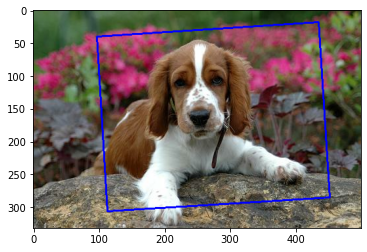

In [51]:
# bbox를 그려보자 
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)  # image, contours, contourIdx, color, thickness 순서 
plt.imshow(image)

## cv2.drawContours - 외곽선 그리기 함수
- 검출한 외곽선을 확인하기 위해 이 함수를 이용하여 외곽선을 화면에 그릴 수 있음, 검증 역할을 하기도 함 
`cv2.drawContours(image, contours, contourIdx, color, thickness, lineType, hierarchy, maxLevel)`
1. image : 입출력 영상
2. contours : cv2.findContours() 함수로 구한 외곽선 좌표 정보
3. contourIdx : 외곽선 인덱스, contours list type에서 몇 번째 외곽선을 그릴 것인지, -1이면 전체 
4. color : 외곽선 색상
5. thickness : 외곽선 두께, 음수면 line의 내부를 채움
6. lineType : LINE_4, _8, _AA 중 하나 지정
7. hierarchy : 외곽선 계층 정보
8. maxLevel : 그리기를 수행할 최대 외곽선 레벨 0이면 contourIdx로 지정된 외곽선만 그린다 

## bbox from Grad-CAM

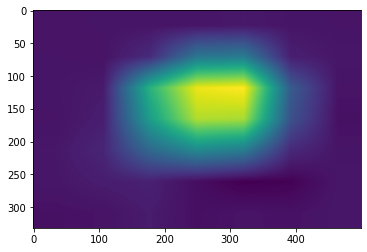

In [52]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

In [53]:
image = copy.deepcopy(item['image'])
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[105, 262],
       [ 90,  39],
       [442,  16],
       [457, 239]])

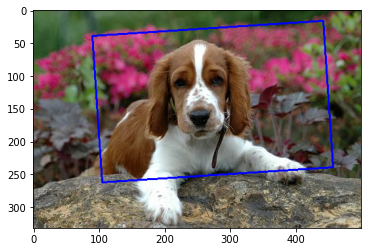

In [54]:
image_grad = cv2.drawContours(image, [grad_rect], 0, (0,0,255), 2)
plt.imshow(image_grad)

# Intersection Over Union
- IoU는 두 개 영역의 합집합인 "union" 영역으로 교집합 영역인 "intersection" 영역의 넓이를 나누어준 값

In [60]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]),  #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1])   #bounding box의 x_max
    ]
    return bbox

In [62]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.05421686746987952, 0.194, 0.9216867469879518, 0.904]

In [63]:
grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
grad_pred_bbox

[0.04819277108433735, 0.18, 0.7891566265060241, 0.914]

In [64]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min = max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])

    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [41]:
get_iou(pred_bbox, item['bbox'])

NameError: ignored

In [ ]:
get_iou(grad_pred_bbox, item['bbox'])

# 회고
- stanford_dogs 데이터셋의 경우 bbox가 주어지지 않은 데이터셋이여서 마지막 iou를 예측한 bbox값과 비교할 수가 없었다. 
- 하지만 CAM과 Grad-CAM 결과 이미지를 봤을 때 CAM 이미지가 좀 더 넓게 개의 발 부분까지 bbox가 다 잡고 있고 Grad-CAM의 경우 발 부분이 잘린 것을 볼 수 있다. 
- CAM의 바운딩 박스가 더 넓기 때문에 IoU를 계산하면 CAM이 Grad-CAM보다 더 높게 나올 것 같다. 

# 참고 
- Numpy 데이터타입(uint8) : 
    1. https://studio-kimhippo.tistory.com/26 
    2. https://engineer-mole.tistory.com/85
- 이미지 컨투어 
    1. https://datascienceschool.net/03%20machine%20learning/03.02.03%20%EC%9D%B4%EB%AF%B8%EC%A7%80%20%EC%BB%A8%ED%88%AC%EC%96%B4.html
    2. https://dsbook.tistory.com/227
    3. 함수 : https://deep-learning-study.tistory.com/231
    4. 계층, 근사화 : https://velog.io/@redorangeyellowy/ch07-%EC%9D%B4%EC%A7%84-%EC%98%81%EC%83%81-%EC%B2%98%EB%A6%AC-%EC%99%B8%EA%B3%BD%EC%84%A0-%EA%B2%80%EC%B6%9C